In [1]:
 import os
 import torch
 import requests
 import zipfile
 from pathlib import Path

In [2]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [3]:
folder_path = "going_modular"

# Create the directory
os.mkdir(folder_path)

In [4]:
%%writefile going_modular/data_setup.py

"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set the number of workers based on the available CPUs
NUM_WORKERS = os.cpu_count() if os.cpu_count() else 2

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    """Creates training and testing DataLoaders for image classification.

    Args:
        train_dir (str): Path to training directory.
        test_dir (str): Path to testing directory.
        transform (torchvision.transforms.Compose): Image transformations.
        batch_size (int): Number of samples per batch.
        num_workers (int): Number of workers for data loading.

    Returns:
        Tuple[DataLoader, DataLoader, List[str]]: Training DataLoader, testing DataLoader, class names.
    """
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(root=train_dir, transform=transform)
    test_data = datasets.ImageFolder(root=test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py


In [5]:
%%writefile going_modular/model_builder.py

"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""

import torch
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 13 * 13, output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

Writing going_modular/model_builder.py


In [6]:
%%writefile going_modular/engine.py

"""
Contains functions for training and testing a PyTorch model.
"""

import torch
from tqdm.auto import tqdm
from typing import Tuple, List, Dict

def train_step(model, dataloader, loss_fn, optimizer, device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(y)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device) -> Dict[str, List[float]]:
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

Writing going_modular/engine.py


In [7]:
from going_modular import data_setup, model_builder, engine
import torch
from torchvision import transforms

# Set up device-agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

train_dir = "/content/data/pizza_steak_sushi/train"
test_dir = "/content/data/pizza_steak_sushi/test"

# Create DataLoaders
batch_size = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=batch_size
)

In [8]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d428e346a10>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Initialize the model
model = model_builder.TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

In [10]:
model

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [11]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Train the model
epochs = 10
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1070 | train_acc: 0.4023 | test_loss: 1.0737 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.1090 | train_acc: 0.2812 | test_loss: 1.0749 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1042 | train_acc: 0.2773 | test_loss: 1.1028 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1064 | train_acc: 0.2930 | test_loss: 1.0939 | test_acc: 0.4527
Epoch: 5 | train_loss: 1.0988 | train_acc: 0.3008 | test_loss: 1.0936 | test_acc: 0.3598
Epoch: 6 | train_loss: 1.0900 | train_acc: 0.4375 | test_loss: 1.1041 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1114 | train_acc: 0.3047 | test_loss: 1.1261 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.1057 | train_acc: 0.3047 | test_loss: 1.1100 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.0976 | train_acc: 0.3086 | test_loss: 1.0990 | test_acc: 0.2188
Epoch: 10 | train_loss: 1.0987 | train_acc: 0.2773 | test_loss: 1.0974 | test_acc: 0.5019


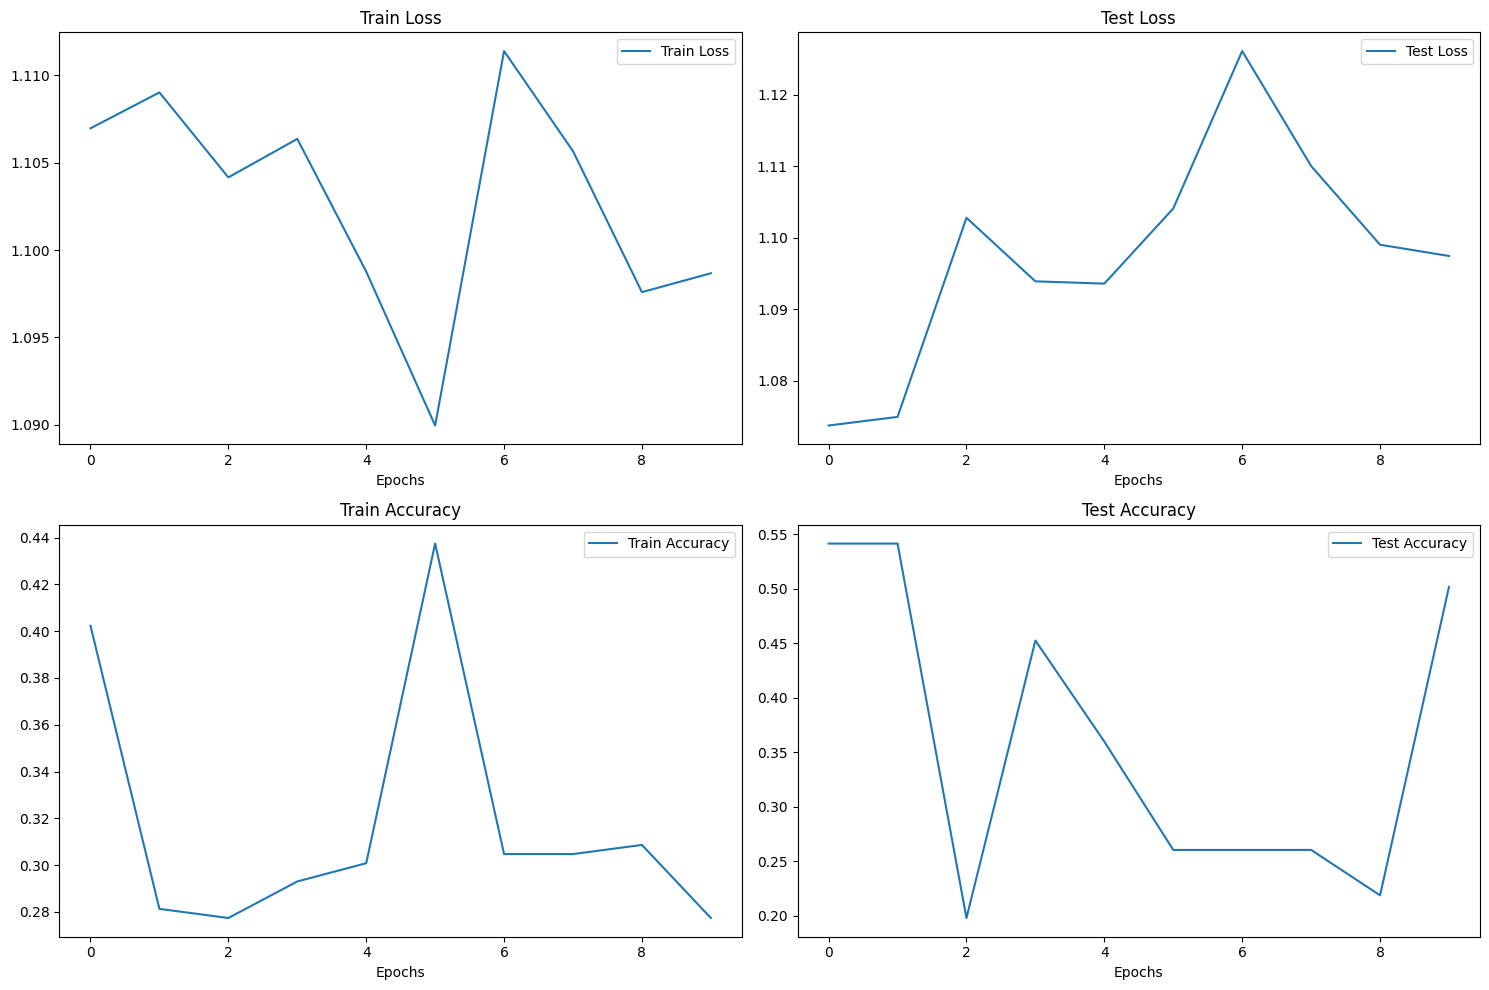

In [13]:
import matplotlib.pyplot as plt

# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs from the length of one of the metric lists
epochs = range(len(results["train_loss"]))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, results["train_loss"], label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, results["test_loss"], label="Test Loss")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, results["train_acc"], label="Train Accuracy")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, results["test_acc"], label="Test Accuracy")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [16]:
%%writefile going_modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing going_modular/utils.py


In [20]:
from going_modular import utils
utils.save_model(model=model, target_dir="models", model_name="tingvgg_model.pth")

[INFO] Saving model to: models/tingvgg_model.pth


In [21]:
%%writefile going_modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
from going_modular import data_setup, engine, model_builder, utils

from torchvision import transforms

# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")

Writing going_modular/train.py


In [26]:
# Run train.py directly in the notebook if you want
%run /content/going_modular/train.py

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1089 | train_acc: 0.2969 | test_loss: 1.1013 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1084 | train_acc: 0.3320 | test_loss: 1.1280 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.0995 | train_acc: 0.2930 | test_loss: 1.1018 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0995 | train_acc: 0.3008 | test_loss: 1.0871 | test_acc: 0.5521
Epoch: 5 | train_loss: 1.0929 | train_acc: 0.3398 | test_loss: 1.0904 | test_acc: 0.2386
[INFO] Saving model to: models/05_going_modular_script_mode_tinyvgg_model.pth


<Figure size 640x480 with 0 Axes>